# Importación de librerías
Importamos todas las librerías necesarias para el análisis exploratorio, el preprocesado, la ingeniería de variables, el modelado, la evaluación y la interpretación de modelos de machine learning. Estas librerías nos permitirán realizar desde visualizaciones básicas hasta interpretaciones avanzadas del modelo.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV     
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek                                     
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_curve, auc, precision_recall_curve, classification_report, confusion_matrix)

import shap
import pickle

from xgboost import XGBClassifier                      
from sklearn.ensemble import RandomForestClassifier 

# Carga de datos y eliminación de columna innecesaria
Cargamos el dataset original y eliminamos la columna `Patient_ID`, ya que se trata de un identificador único que no aporta valor predictivo para nuestro análisis.


In [2]:
df = pd.read_csv('appendix_cancer_prediction_dataset.csv')
df.drop('Patient_ID', axis=1, inplace=True)


# Exploración del dataset
Examinamos la estructura y los tipos de datos del DataFrame para obtener una visión general del número de filas y columnas, así como del tipo de información contenida en cada variable.


In [3]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260000 entries, 0 to 259999
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Country                         260000 non-null  object 
 1   Age                             260000 non-null  int64  
 2   Gender                          260000 non-null  object 
 3   BMI                             260000 non-null  float64
 4   Smoking_Status                  260000 non-null  object 
 5   Alcohol_Consumption             260000 non-null  object 
 6   Family_History_Cancer           260000 non-null  object 
 7   Genetic_Mutations               260000 non-null  object 
 8   Chronic_Diseases                129913 non-null  object 
 9   Physical_Activity_Level         260000 non-null  object 
 10  Diet_Type                       260000 non-null  object 
 11  Radiation_Exposure              260000 non-null  object 
 12  Previous_Cancers

In [4]:
df.head(5)

,Country,Age,Gender,BMI,Smoking_Status,Alcohol_Consumption,Family_History_Cancer,Genetic_Mutations,Chronic_Diseases,Physical_Activity_Level,...,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Tumor_Markers,Symptom_Severity,Diagnosis_Delay_Days,Treatment_Type,Survival_Years_After_Diagnosis,Appendix_Cancer_Prediction
0,China,67,Female,28.6,No,Low,Yes,No,Diabetes,High,...,228,8.1,4.4,361,Negative,Mild,691,Surgery,6.5,Yes
1,Saudi Arabia,83,Female,19.4,No,Low,No,No,Diabetes,Low,...,186,9.7,6.2,235,Negative,Moderate,275,Chemotherapy,1.6,No
2,France,52,Female,17.2,No,Low,Yes,No,Diabetes,Low,...,231,8.2,4.6,269,Negative,Moderate,668,Chemotherapy,0.7,No
3,Russia,71,Male,31.8,Yes,Low,No,No,NaN,High,...,151,6.8,6.0,193,Negative,Moderate,256,Radiation,2.1,No
4,USA,19,Female,17.7,No,Low,No,No,Hypertension,Moderate,...,236,6.7,4.9,396,Negative,Mild,370,Radiation,0.5,No


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,260000.0,53.443331,20.750951,18.0,36.0,53.0,71.0,89.0
BMI,260000.0,24.996457,4.997116,1.1,21.6,25.0,28.4,48.1
Blood_Pressure,260000.0,134.490342,25.961207,90.0,112.0,134.0,157.0,179.0
Cholesterol_Level,260000.0,224.477227,43.266553,150.0,187.0,224.0,262.0,299.0
White_Blood_Cell_Count,260000.0,7.000596,1.496819,0.5,6.0,7.0,8.0,13.7
Red_Blood_Cell_Count,260000.0,4.999148,0.501531,2.8,4.7,5.0,5.3,7.6
Platelet_Count,260000.0,274.433846,72.207496,150.0,212.0,275.0,337.0,399.0
Diagnosis_Delay_Days,260000.0,365.181450,210.924211,0.0,182.0,366.0,548.0,729.0
Survival_Years_After_Diagnosis,260000.0,4.989499,4.976837,0.0,1.4,3.5,6.9,67.8


# Análisis de nulos y distribución de la variable objetivo
Comprobamos el número de valores nulos en cada columna, lo que nos ayuda a decidir la mejor estrategia de imputación o limpieza de datos. También examinamos la distribución de la variable objetivo (`Appendix_Cancer_Prediction`) para identificar si existe desbalance entre las clases.
Convertimos variables categóricas relevantes (`Gender`, `Smoking_Status`, `Appendix_Cancer_Prediction`) en variables numéricas para facilitar su uso en modelos de machine learning. Se crea además una variable binaria para el target, donde 0 representa “No cáncer” y 1 “Cáncer”.

In [6]:
df.isna().sum()

Country                                0
Age                                    0
Gender                                 0
BMI                                    0
Smoking_Status                         0
Alcohol_Consumption                    0
Family_History_Cancer                  0
Genetic_Mutations                      0
Chronic_Diseases                  130087
Physical_Activity_Level                0
Diet_Type                              0
Radiation_Exposure                     0
Previous_Cancers                       0
Blood_Pressure                         0
Cholesterol_Level                      0
White_Blood_Cell_Count                 0
Red_Blood_Cell_Count                   0
Platelet_Count                         0
Tumor_Markers                          0
Symptom_Severity                       0
Diagnosis_Delay_Days                   0
Treatment_Type                     26074
Survival_Years_After_Diagnosis         0
Appendix_Cancer_Prediction             0
dtype: int64

In [7]:
df['Chronic_Diseases'].value_counts()

Chronic_Diseases
Hypertension    77831
Diabetes        52082
Name: count, dtype: int64

In [8]:
df['Treatment_Type'].value_counts()

Treatment_Type
Surgery         103398
Chemotherapy     78269
Radiation        52259
Name: count, dtype: int64

# Tratamiento de nulos categóricos y codificación con LabelEncoder
Tratamos los valores nulos de las variables categóricas clave (`Chronic_Diseases` y `Treatment_Type`) reemplazándolos por una categoría nueva que indica que no tiene tratamiento o enfermedad previa ese paciente.


In [9]:
df['Chronic_Diseases'] = df['Chronic_Diseases'].fillna('None')        
df['Treatment_Type']    = df['Treatment_Type'].fillna('No Treatment') 

df.isna().sum()

Country                           0
Age                               0
Gender                            0
BMI                               0
Smoking_Status                    0
Alcohol_Consumption               0
Family_History_Cancer             0
Genetic_Mutations                 0
Chronic_Diseases                  0
Physical_Activity_Level           0
Diet_Type                         0
Radiation_Exposure                0
Previous_Cancers                  0
Blood_Pressure                    0
Cholesterol_Level                 0
White_Blood_Cell_Count            0
Red_Blood_Cell_Count              0
Platelet_Count                    0
Tumor_Markers                     0
Symptom_Severity                  0
Diagnosis_Delay_Days              0
Treatment_Type                    0
Survival_Years_After_Diagnosis    0
Appendix_Cancer_Prediction        0
dtype: int64

In [10]:
df['Appendix_Cancer_Prediction'].value_counts()

Appendix_Cancer_Prediction
No     220713
Yes     39287
Name: count, dtype: int64

# Visualización exploratoria 
Realizamos diversas visualizaciones para comprender la distribución de la variable objetivo, la forma de las variables numéricas, la relación entre variables mediante boxplots y matriz de correlación, y la relación de variables categóricas con el diagnóstico mediante countplots. Estas gráficas nos ayudan a descubrir patrones, outliers y relaciones importantes antes del modelado.


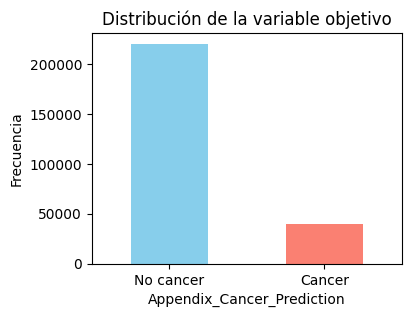

In [11]:
plt.figure(figsize=(4,3))
df['Appendix_Cancer_Prediction'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xticks([0,1], ['No cancer', 'Cancer'], rotation=0)  
plt.title('Distribución de la variable objetivo')
plt.ylabel('Frecuencia')
plt.show()

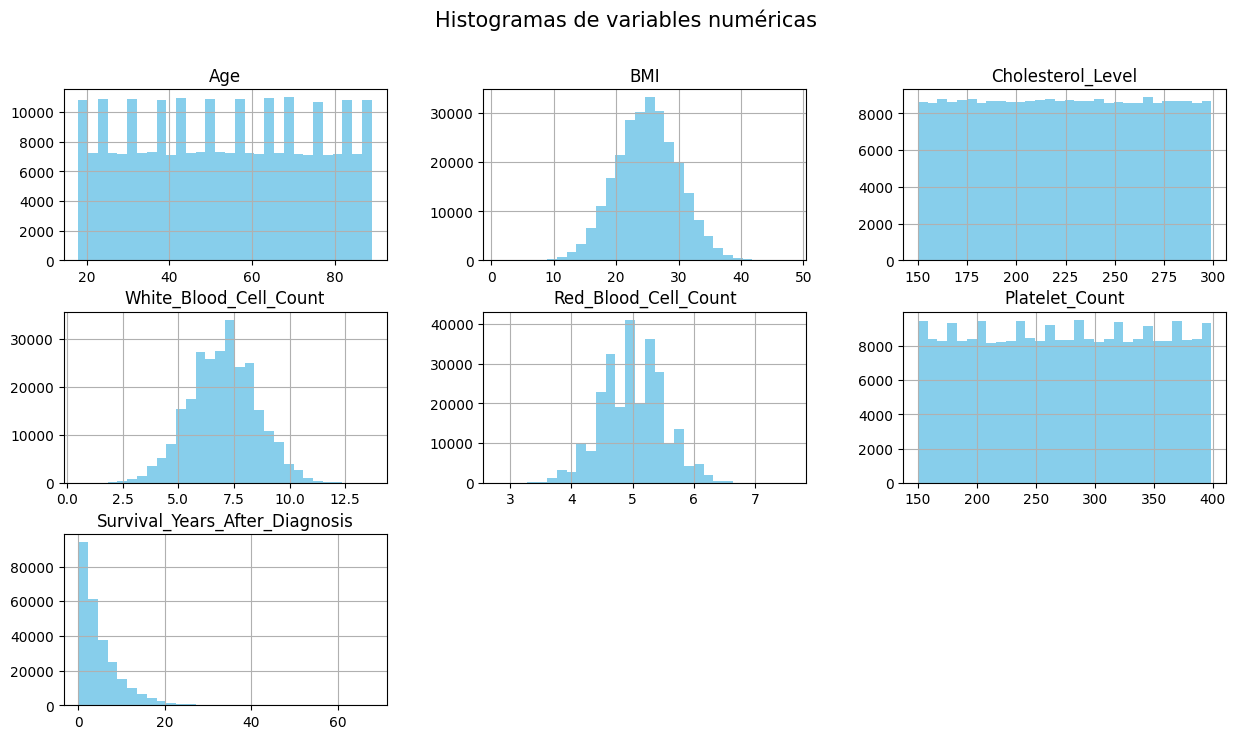

In [12]:
num_cols = ['Age', 'BMI', 'Cholesterol_Level', 'White_Blood_Cell_Count', 'Red_Blood_Cell_Count', 'Platelet_Count', 'Survival_Years_After_Diagnosis']
df[num_cols].hist(bins=30, figsize=(15,8), color='skyblue')
plt.suptitle('Histogramas de variables numéricas', fontsize=15)
plt.show()

/var/folders/6s/rbb4xdjd1d15rp4z5_w0yt8c0000gn/T/ipykernel_29280/2495835009.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Appendix_Cancer_Prediction', y='Age', data=df, palette='pastel')


Text(0.5, 1.0, 'Boxplot Edad vs. Diagnóstico')

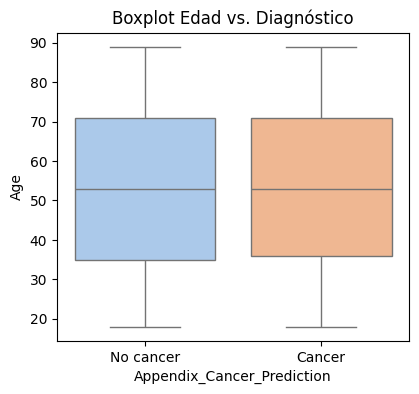

In [13]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Appendix_Cancer_Prediction', y='Age', data=df, palette='pastel')
plt.xticks([0,1], ['No cancer', 'Cancer'])
plt.title('Boxplot Edad vs. Diagnóstico')

/var/folders/6s/rbb4xdjd1d15rp4z5_w0yt8c0000gn/T/ipykernel_29280/4227032536.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Appendix_Cancer_Prediction', y='BMI', data=df, palette='pastel')


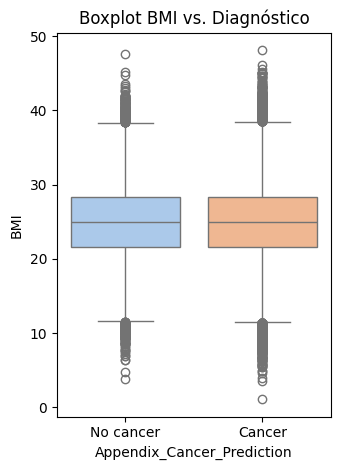

In [14]:
plt.subplot(1,2,2)
sns.boxplot(x='Appendix_Cancer_Prediction', y='BMI', data=df, palette='pastel')
plt.xticks([0,1], ['No cancer', 'Cancer'])
plt.title('Boxplot BMI vs. Diagnóstico')
plt.tight_layout()
plt.show()

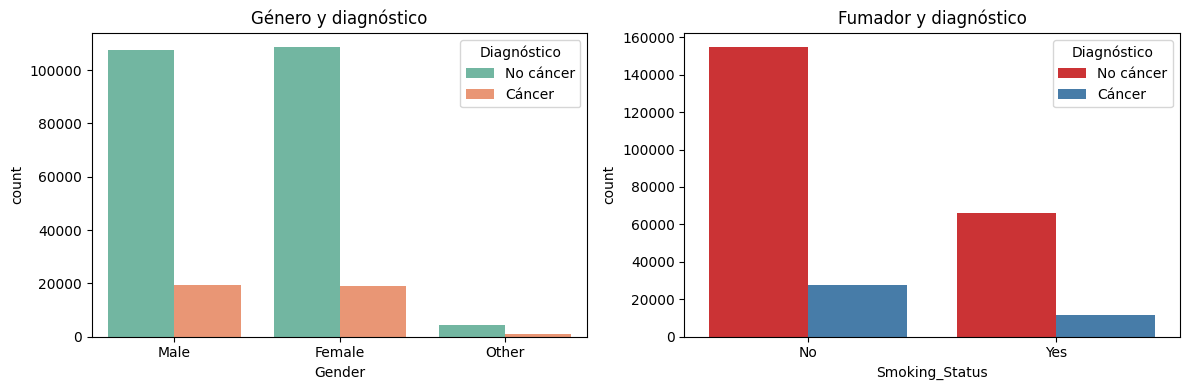

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='Gender', hue='Appendix_Cancer_Prediction', data=df, palette='Set2',
              order=['Male', 'Female', 'Other'],
              hue_order=['No', 'Yes'])
plt.title('Género y diagnóstico')
plt.legend(title='Diagnóstico', labels=['No cáncer', 'Cáncer'])

plt.subplot(1,2,2)
sns.countplot(x='Smoking_Status', hue='Appendix_Cancer_Prediction', data=df, palette='Set1',
              order=['No', 'Yes'],
              hue_order=['No', 'Yes'])
plt.title('Fumador y diagnóstico')
plt.legend(title='Diagnóstico', labels=['No cáncer', 'Cáncer'])
plt.tight_layout()
plt.show()

Aplicamos LabelEncoder a todas las variables categóricas para convertirlas en formato numérico

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260000 entries, 0 to 259999
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Country                         260000 non-null  object 
 1   Age                             260000 non-null  int64  
 2   Gender                          260000 non-null  object 
 3   BMI                             260000 non-null  float64
 4   Smoking_Status                  260000 non-null  object 
 5   Alcohol_Consumption             260000 non-null  object 
 6   Family_History_Cancer           260000 non-null  object 
 7   Genetic_Mutations               260000 non-null  object 
 8   Chronic_Diseases                260000 non-null  object 
 9   Physical_Activity_Level         260000 non-null  object 
 10  Diet_Type                       260000 non-null  object 
 11  Radiation_Exposure              260000 non-null  object 
 12  Previous_Cancers

In [17]:
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col])   

In [18]:
df

,Country,Age,Gender,BMI,Smoking_Status,Alcohol_Consumption,Family_History_Cancer,Genetic_Mutations,Chronic_Diseases,Physical_Activity_Level,...,Cholesterol_Level,White_Blood_Cell_Count,Red_Blood_Cell_Count,Platelet_Count,Tumor_Markers,Symptom_Severity,Diagnosis_Delay_Days,Treatment_Type,Survival_Years_After_Diagnosis,Appendix_Cancer_Prediction
0,4,67,0,28.6,0,1,1,0,0,0,...,228,8.1,4.4,361,0,0,691,3,6.5,1
1,17,83,0,19.4,0,1,0,0,0,1,...,186,9.7,6.2,235,0,1,275,0,1.6,0
2,6,52,0,17.2,0,1,1,0,0,1,...,231,8.2,4.6,269,0,1,668,0,0.7,0
3,16,71,1,31.8,1,1,0,0,2,0,...,151,6.8,6.0,193,0,1,256,2,2.1,0
4,24,19,0,17.7,0,1,0,0,1,2,...,236,6.7,4.9,396,0,0,370,2,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259995,24,33,1,22.3,0,1,0,0,0,1,...,159,7.5,5.2,344,0,1,67,3,1.7,0
259996,1,45,0,27.5,1,2,1,0,1,1,...,268,8.0,5.0,195,0,1,578,2,0.4,1
259997,18,76,1,27.9,1,2,0,0,2,1,...,156,7.8,5.5,201,1,1,670,0,0.0,0
259998,4,68,0,24.0,0,1,0,0,2,2,...,226,7.9,5.1,386,0,1,316,2,8.1,0


# Preparación de datos para el modelado (SMOTE)
Seleccionamos las variables predictoras y la variable objetivo binaria. Aplicamos SMOTE para balancear las clases y evitar sesgos hacia la clase mayoritaria. Finalmente, dividimos el dataset en conjuntos de entrenamiento y prueba de manera estratificada.


In [19]:
target_col = 'Appendix_Cancer_Prediction'           
X = df.drop(columns=['Appendix_Cancer_Prediction', target_col])
y = df[target_col]

print("\nCheck final (target counts):\n", y.value_counts())
print("Shape X/y:", X.shape, y.shape)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote
)


Check final (target counts):
 Appendix_Cancer_Prediction
0    220713
1     39287
Name: count, dtype: int64
Shape X/y: (260000, 23) (260000,)


# Entrenamiento del modelo RF, XGBOOST, LightGBM
Entrenamos diferentes modelos para poder elegir tras evaluar diferentes opciones.

Fitting 3 folds for each of 10 candidates, totalling 30 fits

=== RANDOM FOREST: Mejores parámetros ===
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}

=== Classification Report (Random Forest) ===
              precision    recall  f1-score   support

           0     0.8310    0.7992    0.8148     44143
           1     0.8066    0.8374    0.8217     44143

    accuracy                         0.8183     88286
   macro avg     0.8188    0.8183    0.8183     88286
weighted avg     0.8188    0.8183    0.8183     88286



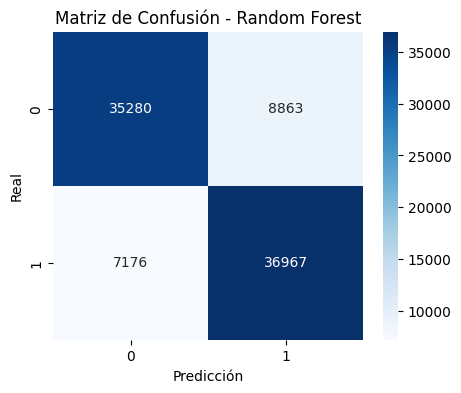

In [29]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
rs_rf = RandomizedSearchCV(rf, param_distributions=rf_params, n_iter=10, scoring='recall', cv=3, n_jobs=-1, verbose=1) 
rs_rf.fit(X_train, y_train)
print('\n=== RANDOM FOREST: Mejores parámetros ===')
print(rs_rf.best_params_)
best_rf = rs_rf.best_estimator_
best_rf.fit(X_train, y_train)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
umbral = 0.4  
y_pred_rf = (y_proba_rf >= umbral).astype(int)
print("\n=== Classification Report (Random Forest) ===")
print(classification_report(y_test, y_pred_rf, digits=4))
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/Users/pedrohd/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:19:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pedrohd/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:19:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pedrohd/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:19:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/pedrohd/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:19:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are


=== XGBOOST: Mejores parámetros ===
{'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


/Users/pedrohd/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [18:20:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Classification Report (XGBoost) ===
              precision    recall  f1-score   support

           0     0.8340    0.8405    0.8372     44143
           1     0.8392    0.8327    0.8360     44143

    accuracy                         0.8366     88286
   macro avg     0.8366    0.8366    0.8366     88286
weighted avg     0.8366    0.8366    0.8366     88286



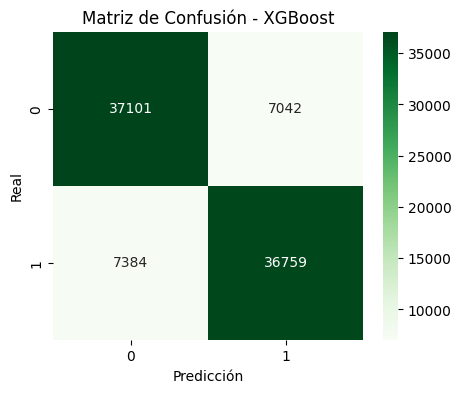

In [24]:
umbral = 0.4  

xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
xgb = XGBClassifier(scale_pos_weight=1, use_label_encoder=False, eval_metric='logloss', random_state=42) 
rs_xgb = RandomizedSearchCV(xgb, param_distributions=xgb_params, n_iter=15, scoring='recall', cv=3, n_jobs=-1, verbose=1) 
rs_xgb.fit(X_train, y_train)
print('\n=== XGBOOST: Mejores parámetros ===')
print(rs_xgb.best_params_)
best_xgb = rs_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = (y_proba_xgb >= umbral).astype(int)
print("\n=== Classification Report (XGBoost) ===")
print(classification_report(y_test, y_pred_xgb, digits=4))
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - XGBoost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 117713, number of negative: 117713
[LightGBM] [Info] Number of positive: 117713, number of negative: 117713
[LightGBM] [Info] Number of positive: 117713, number of negative: 117713
[LightGBM] [Info] Number of positive: 117714, number of negative: 117713
[LightGBM] [Info] Number of positive: 117713, number of negative: 117714
[LightGBM] [Info] Number of positive: 117714, number of negative: 117713
[LightGBM] [Info] Number of positive: 117713, number of negative: 117714
[LightGBM] [Info] Number of positive: 117714, number of negative: 117713
[LightGBM] [Info] Number of positive: 117713, number of negative: 117714
[LightGBM] [Info] Number of positive: 117713, number of negative: 117714
[LightGBM] [Info] Number of positive: 117713, number of negative: 117713
[LightGBM] [Info] Number of positive: 117714, number of negative: 117713
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the o

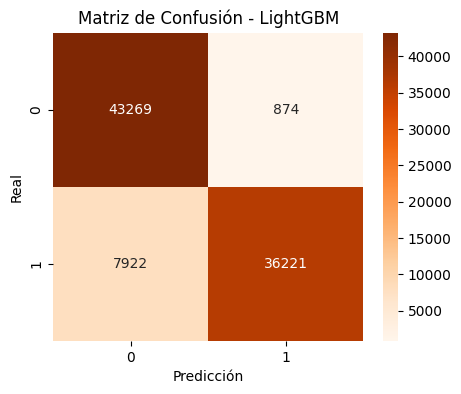

In [25]:
lgbm_params = {
    'num_leaves': [15, 31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, -1],
    'n_estimators': [100, 200, 300],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
rs_lgbm = RandomizedSearchCV(
    lgbm, param_distributions=lgbm_params, 
    n_iter=10, scoring='recall', cv=3, n_jobs=-1, verbose=1
) 
rs_lgbm.fit(X_train, y_train)
print('\n=== LIGHTGBM: Mejores parámetros ===')
print(rs_lgbm.best_params_)
best_lgbm = rs_lgbm.best_estimator_
best_lgbm.fit(X_train, y_train)
y_proba_lgbm = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_lgbm = (y_proba_lgbm >= umbral).astype(int)
print("\n=== Classification Report (LightGBM) ===")
print(classification_report(y_test, y_pred_lgbm, digits=4))
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(5,4))
sns.heatmap(cm_lgbm, annot=True, fmt='d', cmap='Oranges')
plt.title('Matriz de Confusión - LightGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

In [28]:
with open("lgbm.pkl","rb") as f:
    model = pickle.load(f)
model.booster_.save_model("lgbm.txt")
print("✔ lgbm.txt written")

✔ lgbm.txt written


In [27]:
with open('lgbm.pkl', 'wb') as f:
    pickle.dump(best_lgbm, f)

In [30]:
y_proba = best_lgbm.predict_proba(X_test)[:, 1]


# Importancia de variables
Visualizamos la importancia relativa de cada variable según el modelo LightGBM, lo que nos ayuda a identificar cuáles son las características más relevantes en la predicción y posibles oportunidades de reducción de dimensionalidad o ingeniería de variables.


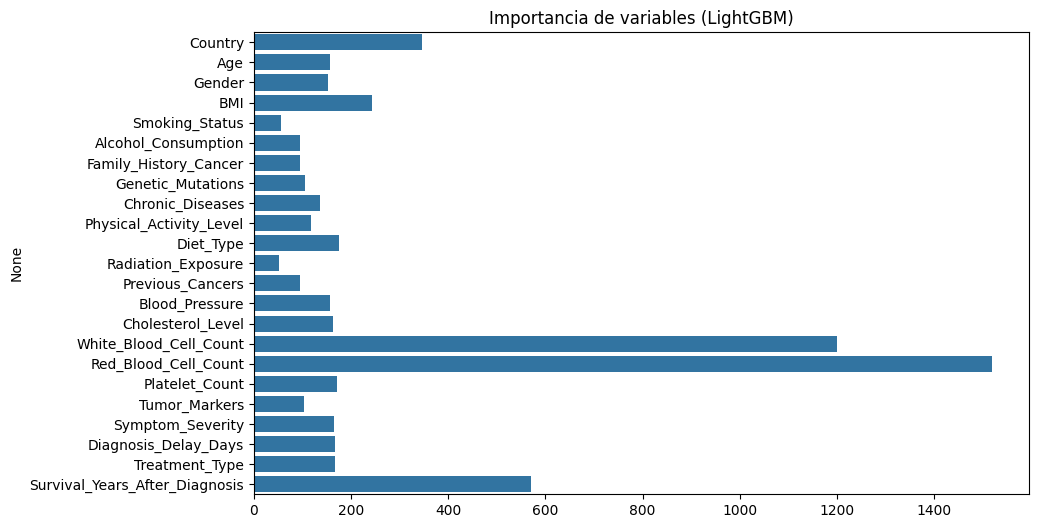

In [31]:
importances = best_lgbm.feature_importances_
features = X.columns
plt.figure(figsize=(10,6))
sns.barplot(x=importances, y=features)
plt.title('Importancia de variables (LightGBM)')
plt.show()

# Curva ROC
Dibujamos la curva ROC (Receiver Operating Characteristic) para evaluar el rendimiento global del modelo en términos de sensibilidad y especificidad, independientemente del umbral de decisión. El área bajo la curva (AUC) resume la capacidad de discriminación del modelo.


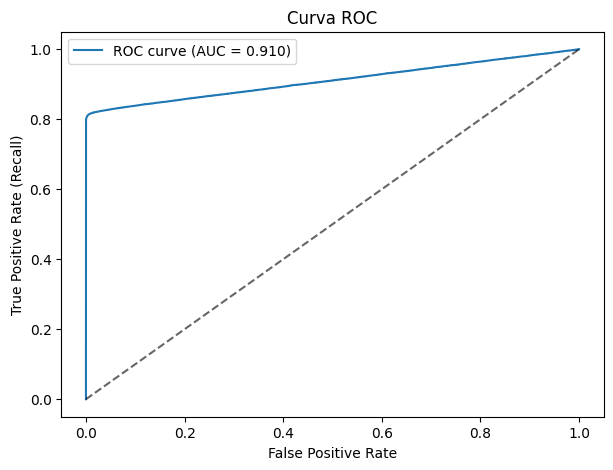

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Curva Precision-Recall
Mostramos la curva Precision-Recall, especialmente útil cuando la clase positiva es minoritaria. Esta curva permite analizar cómo varían la precisión y el recall al modificar el umbral de decisión.


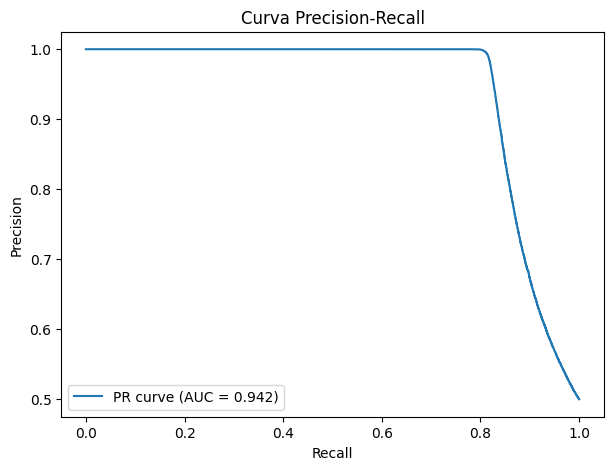

In [33]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.show()

# SHAP
Aplicamos SHAP para interpretar el impacto individual de cada variable sobre las predicciones del modelo LightGBM. Las gráficas SHAP permiten identificar qué variables contribuyen más a cada predicción y entender la lógica detrás de las decisiones del modelo.

100%|===================| 88207/88286 [14:28<00:00]        

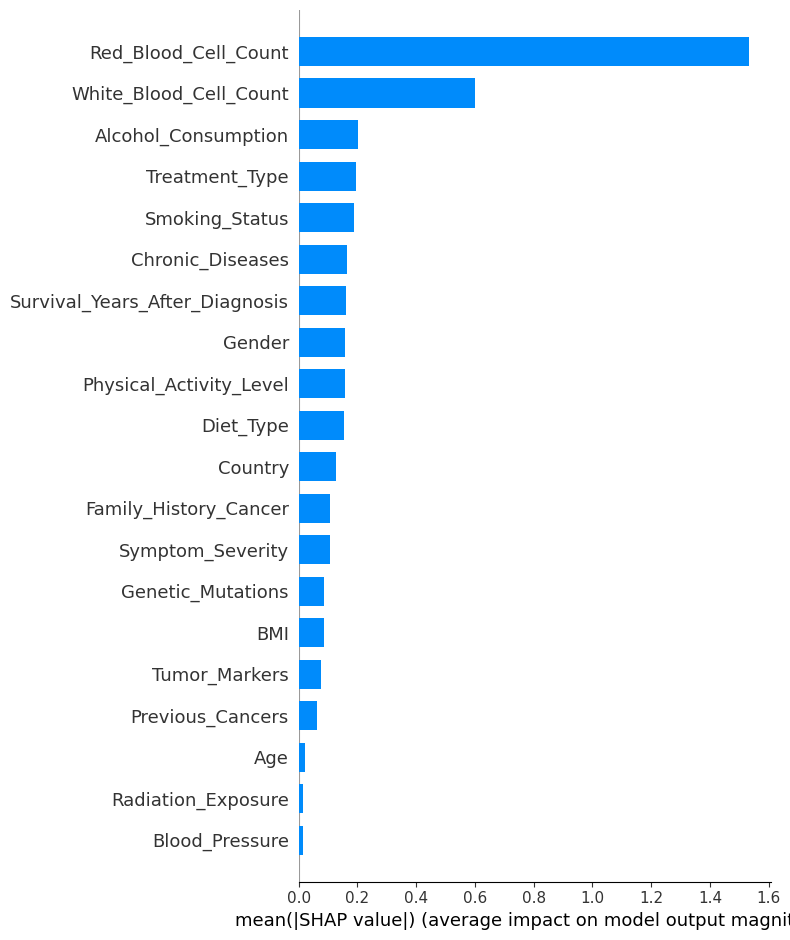

In [34]:
explainer = shap.Explainer(best_lgbm, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")